<a href="https://colab.research.google.com/github/HSE-LAMBDA/MLDM-2022/blob/master/02-linear-regression/LinearRegression_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [99]:
import numpy as np
import matplotlib.pyplot as plt

## Task 1 (3 points)

Consider the following toy dataset:

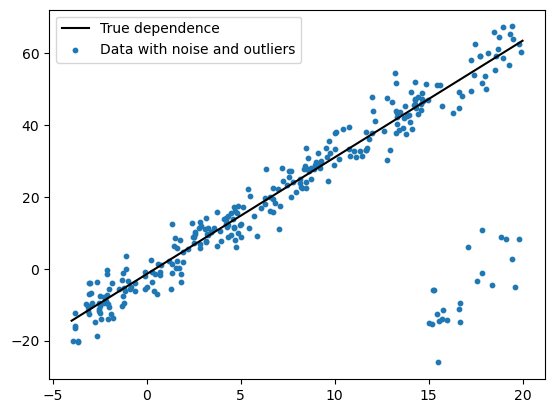

In [100]:
true_function = lambda x: 3.25 * x - 1.47
noize_function = lambda x: (
    np.random.normal(size=len(x)) * 4. +
    np.where(
        x < 15,
        0.,
        -60 + np.random.normal(size=len(x)) * 10
    ) * (np.random.uniform(size=len(x)) < 0.4).astype(int)
)
limits = (-4., 20.)

def generate_dataset(N=300):
  x = np.random.uniform(*limits, size=N)
  y = true_function(x) + noize_function(x)

  return x[:,None], y

X, y = generate_dataset()

x = np.linspace(*limits, 101)
plt.plot(x, true_function(x), c='black', label='True dependence')
plt.scatter(X, y, s=10, label='Data with noise and outliers')
plt.legend();

Implement a linear model $\hat y(x|w) = w_1\cdot x + w_0$ with MAE loss:
$$\text{MAE}(w) = \frac{1}{N}\sum_{i=1}^N\left|y_i - \hat y(x_i|w)\right|,$$
using gradient descent optimization in `numpy`.

*Hint: introduce a constant feature to account for the bias term to make the formulas simpler.*

Plot the learning curve and the final fit. Also, fit the same data with `sklearn`'s `LinearRegression`, and compare the two fits on the same plot. What do you observe? Write a short comment.

## I will do gradient descent with minimizing both MAE and MSE, to better remember 

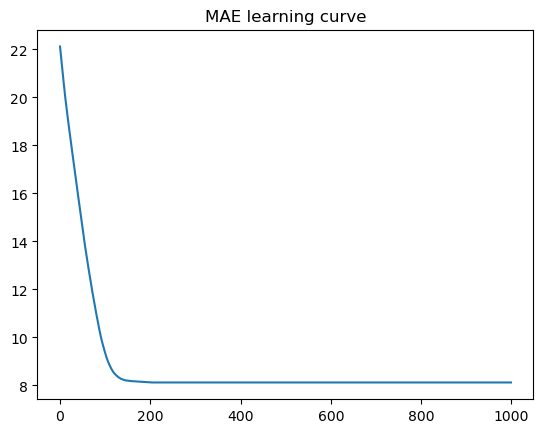

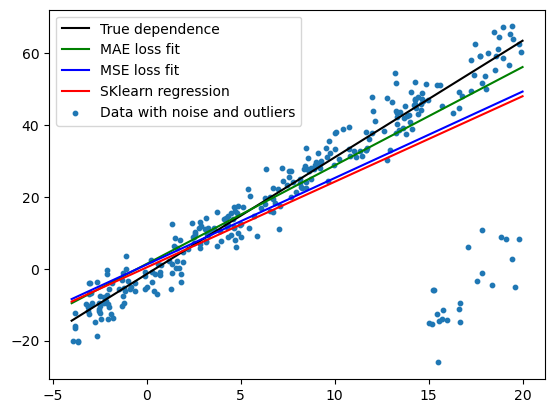

In [101]:
from sklearn.linear_model import LinearRegression

learning_rate = 0.01

# for MAE
def mae_loss(learning_rate, X, y):

    mae_w = np.zeros(X.shape[1])
    mae_b = np.ones(X.shape[1])
    mae_hist = []

    for _ in range(1000):
        
        ## i would like to make gradient descent with also bias corrections
        predictions = X @ mae_w + mae_b
        da = (X * np.where(predictions>y, 1, -1)).mean()
        db = (np.where(predictions>y, 1, -1)).mean()
        
        
        mae_w -= learning_rate * da
        mae_b -= learning_rate * db
        
        mae_hist.append(abs(X@mae_w + mae_b - y).mean()) 

    return mae_w, mae_b, mae_hist

# for MSE
def mse_loss(learning_rate, X, y):
    w = np.zeros(X.shape[1])
    b = np.ones(X.shape[1])
    hist = []


    for _ in range(1000):

               
        da = (-2 * X.T * (y - X @ w) / len(y)).mean()
        db = (-2 * (y - X @ w) / len(y)).mean()

        w -= da * learning_rate
        b -= db * learning_rate

        hist.append(
            (((X@w + b) -y)**2).mean()
        )
    
    return w,b,hist
    
mae_w, mae_b, mae_hist = mae_loss(learning_rate, X, y)
mse_w, mse_b, mse_hist = mse_loss(learning_rate, X, y)
model = LinearRegression()
model.fit(X, y)

plt.plot(mae_hist)
plt.title('MAE learning curve');
plt.show()

x = np.linspace(*limits, 101)
plt.plot(x, true_function(x), c='black', label='True dependence')
plt.plot(x, x*mae_w + mae_b, c='green', label='MAE loss fit')
plt.plot(x, x*mse_w + mse_b, c='blue', label='MSE loss fit' )
plt.plot(x, model.predict(x[:, None]), c='red', label='SKlearn regression' )
plt.scatter(X, y, s=10, label='Data with noise and outliers')
plt.legend()


Comparing three models we can see that MAE loss descent is less sensitive to the noize and outliers, i guess it is connected with that square metric such as MSE adds more penalty to model errors.

## Task 2 (2 + 1 points)

* Wrap your solution from the previous task into a class. Plot the learning curve and the final fit. Compare and comment your results with the previos ones. **(2 points)**

* Make it possible to choose a loss function. **(1 point)**

In [102]:
from sklearn.base import BaseEstimator, RegressorMixin

In [103]:
class LinearRegressionSGD(BaseEstimator, RegressorMixin):
    def __init__(self, 
                 learning_rate=0.01, 
                 n_iterations=100, 
                 batch_size=20,
                 loss='MAE'):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.loss = loss
        self.batch_size = batch_size
        self.hist_loss = []
        
    def fit(self, x, y):
        
        self.hist_loss = [] 

        n = len(x)

        if self.loss == 'MAE':
            w = np.zeros(dtype=float, shape=x.shape[1])
            b = np.ones(dtype=float, shape=x.shape[1])

            for _ in range(self.n_iterations):
                samples = np.random.choice(n, self.batch_size, replace=True)
                prediction = x[samples] @ w + b
                dw = (x[samples] * np.where(prediction > y[samples], 1, -1)).mean()
                db = (np.where(prediction> y[samples], 1, -1)).mean()

                w -= self.learning_rate * dw
                b -= self.learning_rate * db
                self.hist_loss.append((abs(x @ w + b - y)).mean())  

            self.w = w
            self.b = b
            return self

        if self.loss == 'MSE':
            w = np.zeros(dtype=float, shape=x.shape[1])
            b = np.ones(dtype=float, shape=x.shape[1])

            for _ in range(self.n_iterations):
                samples = np.random.choice(n, self.batch_size, replace=True)
                dw = (-2 * x[samples].T * (y[samples] - x[samples] @ w) / x[samples].shape[0]).mean()
                db = (-2 * (y[samples] - x[samples] @ w) / x[samples].shape[0]).mean()

                w -= self.learning_rate * dw
                b -= self.learning_rate * db
                self.hist_loss.append((((x @ w + b) - y) ** 2).mean())  

            self.w = w
            self.b = b
            return self
        else:
            raise ValueError('Invalid loss, please choose from MAE and MSE')

    def predict(self, x):
        return self.w * x + self.b

    def fit_predict(self, x, y):
        self.fit(x, y)
        return self.predict(x)


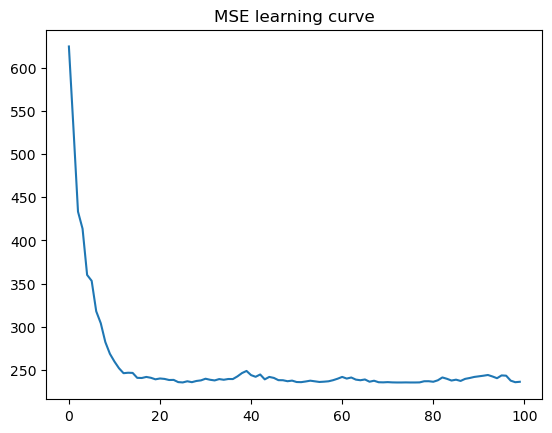

In [104]:
reg = LinearRegressionSGD(loss='MSE', n_iterations=100)
reg.fit_predict(X,y)

plt.plot(reg.hist_loss)
plt.title('MSE learning curve');
plt.show()


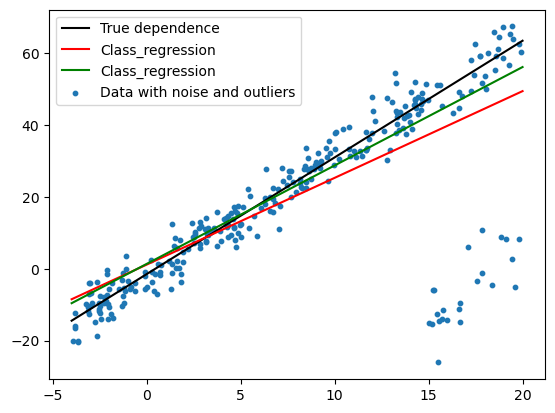

In [105]:
plt.plot(x, true_function(x), c='black', label='True dependence')
plt.plot(x, reg.predict(x), c='red', label='Class_regression')
plt.plot(x, x*mae_w + mae_b, c='green', label='Class_regression')
plt.scatter(X, y, s=10, label='Data with noise and outliers')
plt.legend()

As a conclusion, I packed code from 1 exersise into a class. If we choose the same hyperparameters of non-class model and class model there will be no difference. However packing code into the class allows us to be more universal in model tuning, because we can easily choose what parameters we need and fit the model. Alse we received some sklearn methods for the created class because we inherit it from sklearn classes.